# Prep the data

We need to subset, clean and standardize the data for the UNet model.

Steps are:
* Load the raw data which has lat, lon, variable with gaps (in our case CHL) with gaps indicated with NaN, a land mask and any predictor variables.
* Subset to our smaller region.
* Add season variables (sin/cos)
* Add prior and next day CHL as extra predictors (in addition to the current day CHL)
* Create a fake clouds that will mask observed CHL
* Add masks for fake clouds (has an observed CHL), real clouds (does not have observed CHL), and valid CHL (observed CHL minus CHL covered with fake cloud).

Scroll to bottom for the code to prep all in one code block.

## Load mindthegap code
It is in the `mindthegap` folder in the root level of the repo.

In [ ]:
ROOT_PATH = "/home/jovyan/ohw25_proj_gap/"
import sys, os
repo_root = os.path.abspath(os.path.join(os.getcwd(), ROOT_PATH))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import mindthegap

### Data Preprocessing
#### 1. Load the dataset
We start by loading the dataset of IO.zarr, slicing the region to the desired dimension, and removing days with no valid CHL data.

In [5]:
import xarray as xr
zarr_ds = xr.open_dataset(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr",
    engine="zarr",
    backend_kwargs={"storage_options": {"token": "anon"}},
    consolidated=True
)

In [6]:
# Define bounding box
lat_min, lat_max = 5, 31
lon_min, lon_max = 42, 80

### Show the region

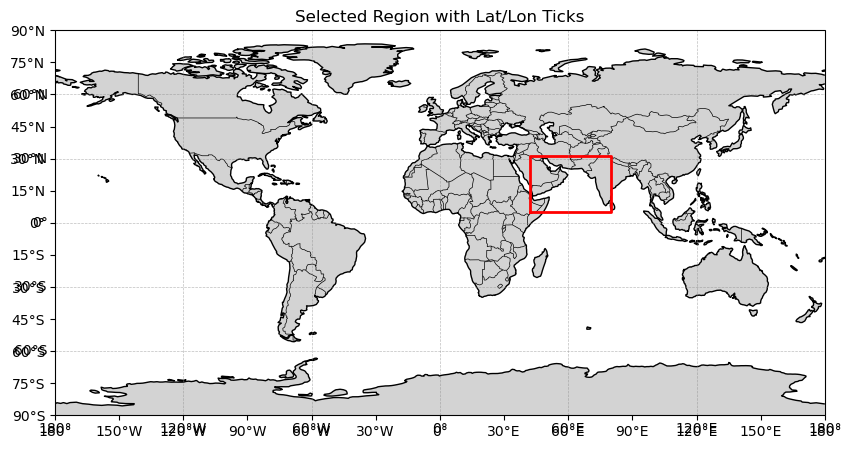

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

# Create a global map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray")

# Plot bounding box
ax.plot(
    [lon_min, lon_max, lon_max, lon_min, lon_min],
    [lat_min, lat_min, lat_max, lat_max, lat_min],
    transform=ccrs.PlateCarree(),
    color="red", linewidth=2
)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False   # no labels at top
gl.right_labels = False # no labels at right

# Control tick locations
ax.set_xticks(range(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(range(-90, 91, 15), crs=ccrs.PlateCarree())

# Format tick labels
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

plt.title("Selected Region with Lat/Lon Ticks")
plt.show()


### Slice and subset

In [7]:
import numpy as np
zarr_ds = zarr_ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min,lon_max))  # choose long and lat

# skip not needed
#all_nan_CHL = np.isnan(zarr_ds['CHL_cmes-level3']).all(dim=["lon", "lat"]).compute()  # find sample indices where CHL is NaN
#zarr_ds = zarr_ds.sel(time=(~all_nan_CHL))  # select samples with CHL not NaN
#zarr_ds = zarr_ds.sortby('time')

In [4]:
zarr_ds

<xarray.Dataset> Size: 25GB
Dimensions:                       (time: 16071, lat: 105, lon: 153)
Coordinates:
  * lat                           (lat) float32 420B 31.0 30.75 ... 5.25 5.0
  * lon                           (lon) float32 612B 42.0 42.25 ... 79.75 80.0
  * time                          (time) datetime64[ns] 129kB 1979-01-01 ... ...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 1GB ...
    CHL_cmes-cloud                (time, lat, lon) uint8 258MB ...
    CHL_cmes-gapfree              (time, lat, lon) float32 1GB ...
    CHL_cmes-land                 (lat, lon) uint8 16kB ...
    CHL_cmes-level3               (time, lat, lon) float32 1GB ...
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 1GB ...
    ...                            ...
    ug_curr                       (time, lat, lon) float32 1GB ...
    v_curr                        (time, lat, lon) float32 1GB ...
    v_wind                        (time, lat, lon) float32 1GB ...
    vg_curr                       (time, lat, lon) float32 1GB ...
    wind_dir                      (time, lat, lon) float32 1GB ...
    wind_speed                    (time, lat, lon) float32 1GB ...
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

#### 2. Process data

#### Function: `data_preprocessing`
This function selects and standardizes feature variables, and store them to a zarr file for easy access in future training and evaluation.

##### Parameters:
- `zarr_ds`: original zarr dataset after region slicing and NaN CHL filtering
- `features`: a list of features available directly from _zarr_ds_
- `train_year`: the first year of train data
- `train_range`: length of train data in year


##### Other Features (X):
- `sin_time`:
$
\sin({\text{day in the year} \over 366} \cdot 2 \pi)
$
for seasonal information
- `cos_time`:
$
\cos({\text{day in the year} \over 366} \cdot 2 \pi)
$
for seasonal information as well
- `masked_CHL` (logged): artifically masked CHL to simulate cloud coverage. Artificial clouds are the overlapping pixels of _current day observed CHL location_ and _10 day after cloud location_
- `prev_day_CHL`: CHL data from the previous day
- `next_day_CHL`: CHL data from the next day
- `land_flag`: flag for land, with 1 = land and 0 = not land
- `real_cloud_flag`: flag for real cloud, with 1 = real cloud and 0 = not real cloud
- `valid_CHL_flag`: flag for observed CHL after applying artifical masks, with 1 = CHL observed and 0 = CHL not observed
- `fake_cloud_flag`: flag for fake cloud, with 1 = fake cloud and 0 = not fake cloud

##### label (y):
- `CHL` (logged): observed CHL

##### Standardization:
First standardize based on train dataset, and then apply the calculated mean and standard deviation to all data. Only numerical features and the label are standardized. Mean and standard deviation of _CHL_ and _masked_CHL_ are stored in a `.npy` file for evaluation. 

#### Function: `create_zarr`
This function creates a zarr file and stores standardized features and label to the zarr file. 

__Note__: If you run the code for the first time (the `data_preprocessing` function creates the zarr file), it is recommended to restart the kernel and release the memory. Otherwise you might run out of memory during the trainning phase.

In [ ]:
# create the zarr file
features = ['sst']
train_year = 2015
train_range = 3
val_range = 1
test_range = 1
datadir = "/home/jovyan/shared-public/mindthegap/data"

import mindthegap as mtg
# mtg.data_preprocessing calls mtg.create_zarr
zarr_label = mtg.data_preprocessing(zarr_ds, features, train_year, train_range, 
                                    zarr_tag="ArabSea", datadir=datadir)
zarr_label

In [2]:
# Later load the data
import xarray as xr
datadir = "/home/jovyan/shared-public/mindthegap/data"
zarr_label="2015_3_ArabSea"
zarr_stdized = xr.open_zarr(f'{datadir}/{zarr_label}.zarr')

In [3]:
zarr_stdized

<xarray.DataArray 'time' (time: 16071)> Size: 129kB
array(['1979-01-01T00:00:00.000000000', '1979-01-02T00:00:00.000000000',
       '1979-01-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      shape=(16071,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 129kB 1979-01-01 1979-01-02 ... 2022-12-31
Attributes:
    axis:           T
    comment:        Data is averaged over the day
    long_name:      time centered on the day
    standard_name:  time

## All the code in one block
Run this to create the smaller dataset for the model.

In [1]:
# Get the full data set
import xarray as xr
zarr_ds = xr.open_dataset(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr",
    engine="zarr",
    backend_kwargs={"storage_options": {"token": "anon"}},
    consolidated=True
)
# Specify the smaller region and subset
lat_min, lat_max = 5, 31
lon_min, lon_max = 42, 80
import numpy as np
zarr_ds = zarr_ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min,lon_max))  # choose long and lat

# create the zarr. Spec the years to use and features
features = ['sst']
train_year = 2015
train_range = 3
val_range = 1
test_range = 1
datadir = "/home/jovyan/shared-public/mindthegap/data"

# functions are in mindthegap
import mindthegap as mtg
zarr_label = mtg.data_preprocessing(zarr_ds, features, train_year, train_range, zarr_tag="ArabSea", datadir=datadir)
zarr_label

label created
raw data features added
CHL logged
sin and cos time calculated
sin time added
cos time added
masked CHL added
prev day CHL added
next day CHL added
land flag added
real cloud flag added
valid CHL flag added
fake cloud flag added
calculating mean and stdev...
calculating mean and stdev...
calculating mean and stdev...
calculating mean and stdev...
calculating mean and stdev...
calculating mean and stdev...
standardizing...
standardizing...
standardizing...
standardizing...
standardizing...
standardizing...
all standardized
creating zarr


'2015_3_ArabSea'